# NAICS Time Series Data Analysis

## Introduction

In this notebook we demonstrate data preparation techniques and analysis using the Employment data classified by industry using the North American Industry Classification System (NAICS). The following steps have been employed in the analysis:

- Definition of functions for transforming and cleaning of the data. The following are the functions that have been defined:

    - Function for Reading .csv Files. The function takes in a list of .csv file names and the path to the folder containing the files. it then reads all the files and stores them as Pandas Dataframes in a list.
    
    - Function for Cleaning the Data. The function takes in a dataframe and performs data cleaning and transformation.
    
    - Function for Filtering All Industry Data. The function takes in a dataframe and returns a dictionary that filters data for each industry. The keys are the industry names and the values are the filtered dataframe for that industry.
    
- Loading the Datasets. 
     - We first start by loading the mapping .csv file for mapping the NAICS numbers to the Industry Details.
     
     - We then load the employement files into a list of dataframes using the defined function for loading .csv files.
     

- Data Preparation. The following are the data preparation processes performed:

    - Cleaning each of the dataframe in the list of dataframes. This ensures that the industries in each NAICS column are represented by the Industry Number and not name
    
    - Merging the Cleaned Data. The dataframes in the list that have been cleaned are merged into one dataframe.
    
    - Data mapping. The mapping dataframe is transformed into a dictionary which is then used to map the Industry Names to the NAICS numbers in the merged dataframe for employment. 
    - Grouping the Merged dataframe. After mapping the dataframe, the dataframe is sorted and grouped by year, month and industry with employment values aggregated by summing
    
- Exploratory Data Analysis. We analyse the data by considering the following explorations:

    - Descriptive Statistics and Distribution
    
    - Evolution of Employment in Construction over Time
    
    - Relationship of Employment in Construction and in Architectural, engineering and related services
    
    - Share of Employment by Industry for Top 10 Industries
    
    - Average Employment Levels per Month



## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## 2. Define Functions

### 2.1 Function for Reading csv files 

In [2]:
def read_files(names_list, folder_path):
    """
    Takes in a list of .csv file names and the path to the files.
    It reads the files into dataframes and returns a list of dataframes
    
    parameters: 
    a list of .csv files names
    path to files folder
            
    returns: 
    a list of dataframes
    
    """
    df_list = []
    for i in names_list:
        file_path = folder_path + i + ".csv"
        df = pd.read_csv(file_path)
        df_list.append(df)
        
    return df_list

### 2.2 Function for Cleaning the Data

In [3]:
def cleaning(df):
    """
    Takes in a dataframe and performs data cleaning 
    Returns the NAICS numbers as intergers
    
    parameters:
    dataframe
    
    returns:
    cleaned dataframe with int64 NAICS column
    
    """
    #check if "NAICS" column is 'Object' type
    if df['NAICS'].dtype == 'O':
        # Extract the values in square brackets if they exist
        df["NAICS_NO"] = df['NAICS'].str.extract(r'\[(.*?)]', expand = False)

        #drop rows with NaN values in the 'NAics_NO' COLUMN
        df.dropna(subset=['NAICS_NO'], inplace=True)
        
        #Split values with dashes and return the first value
        df['Splitted_Values'] = df['NAICS_NO'].str.split("-", expand=False)
        df['Left_Value'] = df['Splitted_Values'].str.get(0)
        df['Left_Value'].fillna(df['NAICS_NO'], inplace=True)
        
        #convert "Left_Value" to "int64" type
        df['Left_Value'] = df['Left_Value'].astype("int64")
        
        #filter to return the original columns and filtered Left_Value Column
        df = df[["SYEAR", "SMTH", 'Left_Value', "_EMPLOYMENT_"]]
           
    else:
        df = df
    
    #rename columns
    df.columns = ["SYEAR", "SMTH", 'NAICS', "_EMPLOYMENT_"]
        
    return df

### 2.3 Function for Filtering All Industry Data

In [4]:
def industry_data(grouped_df):
    """
    Takes in a dataframe and returns a dictionary with:
    key: Industry Name
    value: Filtered Dataframe of the Industry
    
    parameters:
    dataframe
    
    returns:
    dictionary of Industry name: Filtered dataframe for the industry
    
    """
    data = {}
    for i in list(grouped_df['LMO_Detailed_Industry']):
        key = i
        value = grouped_df[grouped_df['LMO_Detailed_Industry']==i]
        data[key] = value
        
    return data  

## 3. Load the Datasets

### 3.1 Load the RTRA Data Mapping File

In [5]:
# load csv file for mapping the NAICS numbers to the Industry Details
mapping_df = pd.read_excel("data/LMO_Detailed_Industries_by_NAICS.xlsx")

mapping_df.head()

,LMO_Detailed_Industry,NAICS
0,Farms,111 & 112
1,"Fishing, hunting and trapping",114
2,Forestry and logging,113
3,Support activities for agriculture and forestry,115
4,Oil and gas extraction,211


### 3.2 Load the RTRA Employment Data Files

In [6]:
# a list of the file names
names_list = ["RTRA_Employ_2NAICS_00_05", "RTRA_Employ_2NAICS_06_10", "RTRA_Employ_2NAICS_11_15",
             "RTRA_Employ_2NAICS_16_20", "RTRA_Employ_2NAICS_97_99", "RTRA_Employ_3NAICS_00_05",
             "RTRA_Employ_3NAICS_06_10", "RTRA_Employ_3NAICS_11_15", "RTRA_Employ_3NAICS_11_15",
             "RTRA_Employ_3NAICS_97_99", "RTRA_Employ_4NAICS_00_05", "RTRA_Employ_4NAICS_06_10",
             "RTRA_Employ_4NAICS_11_15", "RTRA_Employ_4NAICS_16_20", "RTRA_Employ_4NAICS_97_99"]

# read the csv files using the read_files function
data_list = read_files(names_list, "data/")

# view the head of the first loaded dataframe
data_list[0].head()

,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,Accommodation and food services [72],148000
1,2000,1,"Administrative and support, waste management a...",59250
2,2000,1,"Agriculture, forestry, fishing and hunting [11]",61750
3,2000,1,"Arts, entertainment and recreation [71]",39500
4,2000,1,Construction [23],106250


## 4. Data Preparation

### 4.1 Cleaning the data in the Dataframe List

In [7]:
# create a list of cleaned dataframes using the cleaning function
cleaned_df_list = [cleaning(data_list[i]) for i in range(len(data_list))]

# view the head of the first cleaned dataframe
cleaned_df_list[0].head()

,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,72,148000
1,2000,1,56,59250
2,2000,1,11,61750
3,2000,1,71,39500
4,2000,1,23,106250


### 4.2 Merging the Cleaned Dataframes

In [8]:
# Concatenate the cleaned dataframes in the list
merged_df = pd.concat(cleaned_df_list)

#display the merged_df head and shape
display(merged_df.head())
display(merged_df.shape)

,SYEAR,SMTH,NAICS,_EMPLOYMENT_
0,2000,1,72,148000
1,2000,1,56,59250
2,2000,1,11,61750
3,2000,1,71,39500
4,2000,1,23,106250


(119880, 4)

### 4.3 Data Mapping

#### 4.3.1 Create a Mapping Dictionary from the Mapping Dataframe

In [9]:
#replace the '&' with ',' seperator
map_df_01 = mapping_df.copy()
map_df_01['NAICS'] = mapping_df['NAICS'].str.replace('&', ',')
map_df_01['NAICS'].fillna(mapping_df['NAICS'], inplace = True)

#split the strings using the ',' seperator
map_df = map_df_01.copy()
map_df['NAICS'] = map_df_01['NAICS'].str.split(',')
map_df['NAICS'].fillna(map_df_01['NAICS'], inplace = True)

map_df.head()

,LMO_Detailed_Industry,NAICS
0,Farms,"[111 , 112]"
1,"Fishing, hunting and trapping",114
2,Forestry and logging,113
3,Support activities for agriculture and forestry,115
4,Oil and gas extraction,211


In [10]:
#transform NAICS column to have lists

#get the NAICS Column
naics_col = map_df['NAICS']

#create a list of lists
col_list = []
for i in range(len(naics_col)):
    if type(naics_col[i]) == list:
        value = naics_col[i]
        
    else:
        value = [naics_col[i]]
    
    value = list(map(str, value))
    value = list(map(str.strip, value))
        
    col_list.append(value)

#replace the 'NAICS' column in the map_df
map_df['NAICS'] = col_list

map_df.head()

,LMO_Detailed_Industry,NAICS
0,Farms,"[111, 112]"
1,"Fishing, hunting and trapping",[114]
2,Forestry and logging,[113]
3,Support activities for agriculture and forestry,[115]
4,Oil and gas extraction,[211]


In [11]:
# Create a dictionary from the mapping DataFrame
mapping_dict = {}
for old_val, new_val in zip(map_df['NAICS'], map_df['LMO_Detailed_Industry']):
    for val in old_val:
        mapping_dict[val.strip(',')] = new_val
        
mapping_dict

{'111': 'Farms',
 '112': 'Farms',
 '114': 'Fishing, hunting and trapping',
 '113': 'Forestry and logging',
 '115': 'Support activities for agriculture and forestry',
 '211': 'Oil and gas extraction',
 '213': 'Support activities for mining and oil and gas extraction',
 '212': 'Mining',
 '22': 'Utilities',
 '23': 'Construction',
 '311': 'Food, beverage and tobacco manufacturing',
 '312': 'Food, beverage and tobacco manufacturing',
 '321': 'Wood product manufacturing',
 '322': 'Paper manufacturing',
 '331': 'Primary metal manufacturing',
 '332': 'Fabricated metal product manufacturing',
 '333': 'Machinery manufacturing',
 '3366': 'Ship and boat building',
 '3361': 'Transportation equipment manufacturing (excluding shipbuilding)',
 '3362': 'Transportation equipment manufacturing (excluding shipbuilding)',
 '3363': 'Transportation equipment manufacturing (excluding shipbuilding)',
 '3364': 'Transportation equipment manufacturing (excluding shipbuilding)',
 '3365': 'Transportation equipment 

#### 4.3.2 Map the NAICS to Industry Details using the Mapping Dictionary

In [12]:
# Map the Columns of 'NAICS' in the Merged DF with valus in the maping dictionary
merged_df['NAICS'] = merged_df['NAICS'].astype(str).map(mapping_dict)

#rename columns
merged_df.columns = ['SYEAR', 'SMTH', 'LMO_Detailed_Industry', 'Employment']

# drop NaN values 
merged_df.dropna(subset=['LMO_Detailed_Industry'], inplace=True)

#sort the mnerged dataframe
merged_df = merged_df.sort_values(by = ['SYEAR', 'SMTH', 'LMO_Detailed_Industry'])

merged_df.head()

,SYEAR,SMTH,LMO_Detailed_Industry,Employment
1,1997,1,Accommodation services,24000
3,1997,1,Air transportation,17000
4,1997,1,Ambulatory health care services,40000
5,1997,1,"Amusement, gambling and recreation industries",20000
236,1997,1,"Architectural, engineering and related services",27000


#### 4.3.3 Group the Merged dataframe

In [13]:
#define the variables to groupby
grouped = merged_df.groupby(['SYEAR', 'SMTH', 'LMO_Detailed_Industry'])

#aggregate the grouped 
grouped_df = grouped[['Employment']].sum()

#reset index of the grouped dataframe
grouped_df = grouped_df.reset_index()

#combine Year and Month Columns to a Date Column
grouped_df['DATE'] = pd.to_datetime(grouped_df.SYEAR.astype(str) + '/' + grouped_df.SMTH.astype(str) + '/01')

#filter for relevant columns only
grouped_df = grouped_df[['DATE', 'SYEAR', 'SMTH', 'LMO_Detailed_Industry', 'Employment']]

#view the head of the dataframe
grouped_df.head()

,DATE,SYEAR,SMTH,LMO_Detailed_Industry,Employment
0,1997-01-01,1997,1,Accommodation services,24000
1,1997-01-01,1997,1,Air transportation,17000
2,1997-01-01,1997,1,Ambulatory health care services,40000
3,1997-01-01,1997,1,"Amusement, gambling and recreation industries",20000
4,1997-01-01,1997,1,"Architectural, engineering and related services",27000


## 5. Exploratory data Analysis (EDA)

We explore the employment data across the different industries and address the following questions:

1. Descriptive Statistics and Distribution


2. Evolution of Employment in Construction over Time


2. Relationship of Employment in Construction and in Architectural, engineering and related services


3. Share of Employment by Industry for Top 10 Industries


4. Average Employment Levels per Month

### 5.1 Descriptive Statistics and Distribution

From the descriptive statistics we note that the employment data has a wide range and variability with a minimum of zero employment recorded in some instances to a maximum of 524500. The histogram plot shows a distribution which is skewed to the right with observable outliers. For the purpose of this analysis, we will not remove the outliers but will take into consideration their presense when making any sort of interpretetions.

In [14]:
#get descriptive statistics for Employment
grouped_df.describe()[['Employment']].T

,count,mean,std,min,25%,50%,75%,max
Employment,13992.0,42883.433391,54058.626258,0.0,12000.0,26000.0,53750.0,524500.0


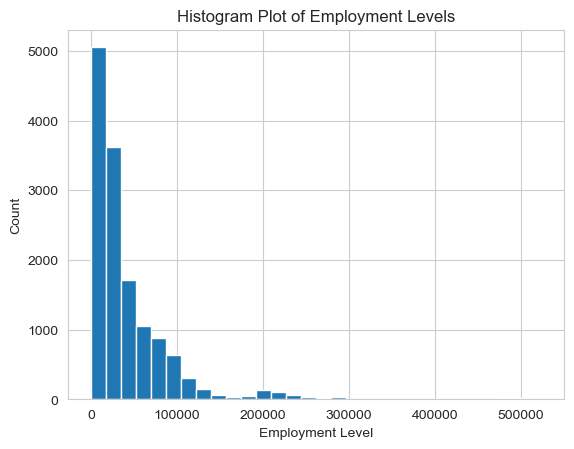

In [15]:
#histogram plot of employment
plt.hist(grouped_df['Employment'], bins = 30)
plt.title('Histogram Plot of Employment Levels')
plt.xlabel('Employment Level')
plt.ylabel('Count')
plt.show()

### 5.2 Evolution of Employment in Construction over Time

In [16]:
# get all the Industry data
industry_data = industry_data(grouped_df)

#Get Construction data
construction_data = industry_data['Construction']

#average construction by year
construction_by_year = construction_data.groupby('SYEAR')['Employment'].mean()

#average of all instustries by year
all_by_year = grouped_df.groupby('SYEAR')['Employment'].mean()

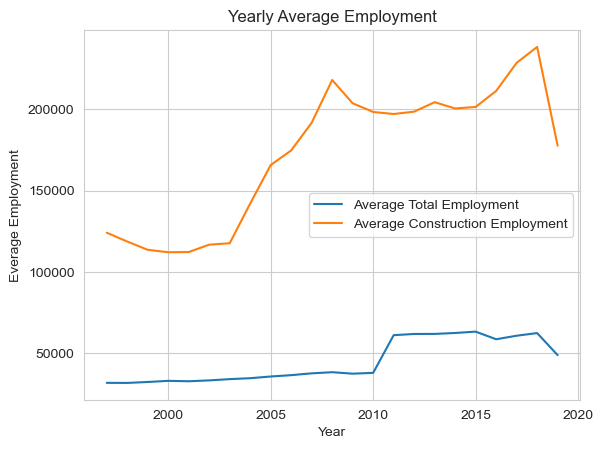

In [20]:
#plot of year to year employment data
plt.plot(all_by_year, label = 'Average Total Employment')
plt.plot(construction_by_year, label = 'Average Construction Employment')
plt.title('Yearly Average Employment')
plt.xlabel('Year')
plt.ylabel('Everage Employment')
plt.legend()

plt.show()

From the analysis of the evolution of the employment in the Construction industry, we note that the employment levels steadily increased from around 2004 after a period of relatively no movement from before 2000. This steady average increase continued to somewhere around 2008 when again a relatively no movement was observed until 2015 when again employment levels increased. This increase went to somewhere 2017 after which a sharp decline was noticed from 2017.

Compared to the overall average, the Construction average is higher. This can be due to the fact that the Construction numbers maybe on a higher outlier end which affects the average. The overall employment showed only slight increase from before 2000 to 2010 when a an increase was noticed up to 2011 before another flat period started lasting till 2018 when the levels dropped. 

### 5.3 Relationship of Employment in Construction and in Architectural, engineering and related services

We explore whether the employment levels in the Construction industry as a whole as an effect on employment levels of Architectural, engineering and related services. This will provide us with insights of whether the increased construction employment results in increases Architectural, engineering and related services which will inform us as to whether construction works are utilizing the services of qualifies Architects and Engineers.

In [22]:
#get data for Architectural, engineering and related services
act_eng_data = industry_data['Architectural, engineering and related services']
act_eng_data.head()

,DATE,SYEAR,SMTH,LMO_Detailed_Industry,Employment
4,1997-01-01,1997,1,"Architectural, engineering and related services",27000
62,1997-02-01,1997,2,"Architectural, engineering and related services",27750
120,1997-03-01,1997,3,"Architectural, engineering and related services",29250
178,1997-04-01,1997,4,"Architectural, engineering and related services",27750
236,1997-05-01,1997,5,"Architectural, engineering and related services",29750


In [23]:
act_eng_data.shape

(276, 5)

In [24]:
construction_data.shape

(276, 5)

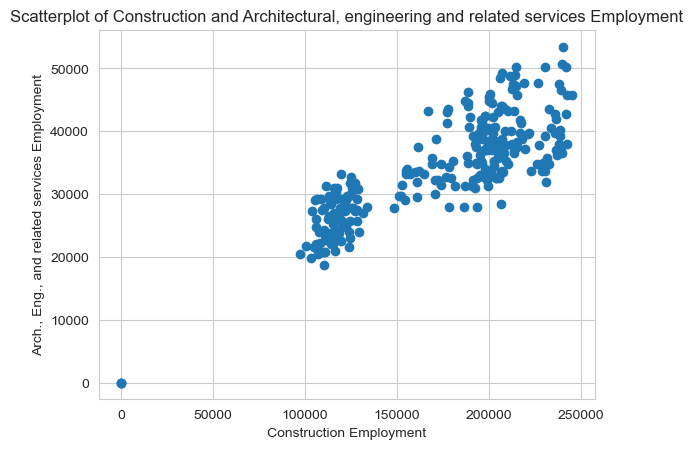

In [25]:
#plot scatterplot of Construction and Architectural, engineering and related services Employment
plt.scatter(construction_data['Employment'], act_eng_data['Employment'])
plt.title('Scatterplot of Construction and Architectural, engineering and related services Employment')
plt.xlabel('Construction Employment')
plt.ylabel('Arch., Eng., and related services Employment')
plt.show()

In [26]:
#correlation coefficient
np.corrcoef(construction_data['Employment'].values,
            act_eng_data['Employment'].values)

array([[1.       , 0.8443105],
       [0.8443105, 1.       ]])

We note that the scatterplot of the Construction Employment and the Architectural, engineering and related services Employment shows a strong positive linear relationship. An increase in Construction Employment overall leads to an increase in the Architectural, engineering and related services Employment. this is confirmed by a positive correlation coefficient of 0.844. This indicates that the increase in construction works do result in an increase in the use of qualifies Architects and Engineers.

### 5.4 Share of Employment by Industry for Top 10 Industries
We explore the share of employment by industry to uncover which industries employs more compared to the other industries. We will consider the top 10 Industries in terms of employment

In [79]:
#group the average employement per Industry
avg_per_industry = grouped_df.groupby('LMO_Detailed_Industry')['Employment'].mean()

top_10 = avg_per_industry.sort_values(ascending = False).head(10)
print(top_10)

LMO_Detailed_Industry
Other retail trade (excluding cars and personal care)     293994.517544
Construction                                              172523.550725
Food services and drinking places                         167935.307018
Hospitals                                                 107783.991228
Repair, personal and non-profit services                   98200.181159
Business, building and other support services              87190.217391
Elementary and secondary schools                           83140.398551
Ambulatory health care services                            81755.482456
Wholesale trade                                            77363.224638
Other manufacturing                                        74714.912281
Name: Employment, dtype: float64


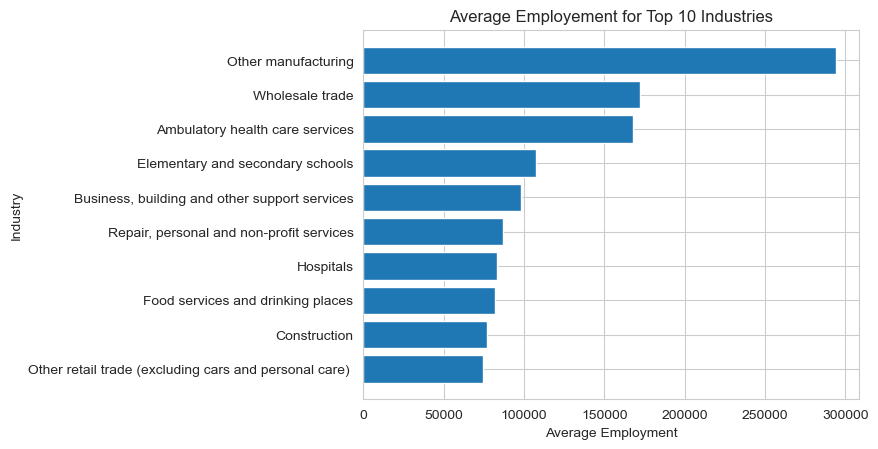

In [80]:
#Plot Horizontal Barplot of the Top 10 Industries
plt.barh(top_10.index, top_10.sort_values().values)
plt.title('Average Employement for Top 10 Industries')
plt.xlabel('Average Employment')
plt.ylabel('Industry')
plt.show()

We note that the Other Manufacturing industry has the highest levels of employment. This is followed by the Wholesale trade. Construction is on number 9 on the top ten industries.

### 5.5 Average Employment Levels per Month

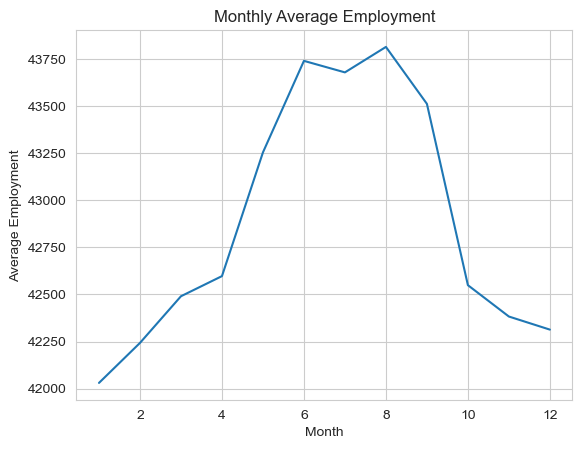

In [78]:
#group the average data by month
monthly_avg = grouped_df.groupby('SMTH')['Employment'].mean()

#plot monthly average employement
plt.plot(monthly_avg)
plt.title('Monthly Average Employment')
plt.xlabel('Month')
plt.ylabel('Average Employment')
plt.show()

To understand the changes in employment levels over the months of the year we look at the average employment levels for each month. We note that the distribution of the employment levels over the moths has close to a bell shaped distribution with majority of employment being within the mid year and reduced levels during the start and end of year.